# Lab: MAE - Self-Supervised Training of ViT in Pytorch

**Student: Lucas Versini**

For any remark or suggestion on this lab, please feel free to contact me at:

- loic.lefolgoc@telecom-paris.fr

### Objective:

We are going to pretrain a Vision Transformer (ViT) using the Masked Auto-Encoding approach, before fine-tuning it for image recognition. We will use this model on a well-known dataset: CIFAR-10 https://www.cs.toronto.edu/~kriz/cifar.html.

The model will be implemented using the Pytorch environment : https://pytorch.org/.
    
### Your task:
You need to add the missing parts in the code (generally marked by `...`)

__Please upload the lab by the deadline as a .ipynb or a .zip named SURNAME_FirstName.ipynb or .zip__

# Load packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
from tqdm import tqdm

In [ ]:
!pip install einops

In [4]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [ ]:
!pip install timm

In [6]:
from timm.layers import trunc_normal_
from timm.models.vision_transformer import Block

# Load the dataset: CIFAR-10

We are going to train a vision transformer on a well-known vision dataset : CIFAR10. CIFAR10 consists of $60,000$ $32\times 32$ color images of $10$ different object classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [7]:
# The CIFAR10 categories
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

We import the CIFAR-10 data and carry out some pre-processing :

In [8]:
# Convert input to Pytorch tensors
input_transform=transforms.Compose( [transforms.ToTensor()])

# Retrieve CIFAR training data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=input_transform)
print(cifar_trainset)

# Retrieve test data
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=input_transform)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Files already downloaded and verified


In [9]:
# Extract the test data and labels for later (visualization of the results)
X_test = torch.from_numpy(cifar_testset.data/255.0).float().permute(0,3,1,2)
Y_test = torch.tensor(cifar_testset.targets, dtype=torch.uint8)

# Build the MAE model

An MAE model consists of a standard transformer encoder and of a decoder.

The encoder is in charge of learning patch representations (token embeddings) that somehow capture their semantic context (the object they belong to, their situation with respect to the other tokens, etc.) The encoder does not see all patches in the image (many patches are masked).

The decoder is in charge of reconstructing the full image from the reduced set of token embeddings seen by the encoder. The decoder is similar in design to the encoder, except it has a final regression head that projects each spatial token to a patch (predicting pixel values of the reconstructed image).

Another difference in implementation of the MAE encoder/decoder (compared to a standard ViT encoder) is that they shuffle/mask/remove (MAE encoder), or unshuffle (MAE decoder) spatial tokens in the forward pass.

<br>Most of the pieces of code you will have to complete in the `MAE_Encoder` and `MAE_Decoder` relate to these specificities. We are going to build the model step-by-step.

Let's complete helper functions first. Use `shuffle` and `argsort` from numpy to complete the function `random_indices` according to its description.

In [10]:
def random_indices(size : int):
    '''
    Returns two outputs:
    forward_indices: np.array (size,) An array of indices between 0 and size-1 in random order
    backward_indices: np.array (size,) The array of indices that reorders forward_indices back to an ordered, increasing list of numbers
      i.e. forward_indices[backward_indices] = np.arange(size)
    '''
    forward_indices = np.random.permutation(size)
    backward_indices = np.argsort(forward_indices)
    return forward_indices, backward_indices

Use `torch.gather` to complete the helper function `take_indices` according to its description.

In [11]:
def take_indices(tokens, indices):
    '''
    tokens: (N, B, C) tensor, tokens[n, b, c] is the c-th entry of the n-th token in the b-th token sequence in the minibatch
    indices: (N', B) tensor, giving the indices of the N' tokens to retrieve from the token sequence, for all token sequences in the minibatch

    output: (N', B, C) tensor, corresponding to the N' tokens corresponding to the desired indices
    '''

    # Hint: use repeat (from einops) to expand indices to an (N', B, C) tensor
    # then torch.gather to retrieve correct tokens
    return torch.gather(tokens, 0, repeat(indices, 'n b -> n b c', c = tokens.shape[2]))

<br>Right after tokenizing an image into patches, creating the patch embeddings, and adding positional embeddings, the `MAE_Encoder` shuffles the token embeddings and discards some of them. This is done by the `PatchShuffle` module below.

In [12]:
class PatchShuffle(torch.nn.Module):
    '''
    Shuffles the token embeddings for a minibatch (different reordering for different minibatch samples),
    then discards some of them.

    Attributes:
      ratio: Scalar in (0,1): the fraction of discarded patches
    '''
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        '''
        Takes the token embeddings (patches) as input.
        Generates a random reordering (forward_indices) and the mapping back to the original order (backward_indices)
        and shuffles token embeddings accordingly. Then, discards a number of patches.
        '''

        N, B, C = patches.shape
        N_kept = int(N * (1 - self.ratio))

        # The random forward and backward indices for reordering each token sequence in the minibatch:
        # (format: list of (forward_indices,backward_indices) tuples)
        indices = [random_indices(N) for _ in range(B)]

        # Cast them to torch tensors:
        forward_indices = torch.as_tensor([i[0] for i in indices], dtype = torch.long).to(patches.device).T
        backward_indices = torch.as_tensor([i[1] for i in indices], dtype = torch.long).to(patches.device).T

        # Retrieve (in 'patches') the token embeddings corresponding to the N_kept first indices in forward_indices
        patches = take_indices(patches, forward_indices[:N_kept])

        # Return
        return patches, forward_indices, backward_indices

<br>We now turn towards implementing the `MAE_Encoder`. It contains:
- a 'stem' `self.patchify` that turns images into token embeddings;
- positional embeddings and the cls token;
- transformer encoder blocks `Block` from the `timm` library (that implement the MHSA layer, feed-forward layer, and put it all together);
- and finally, a `PatchShuffle` layer as implemented above, to shuffle and drop tokens

In [13]:
class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 mlp_ratio=4,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))

        # Tokenization / patch embedding layer
        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        # Token shuffling layer
        self.shuffle = PatchShuffle(mask_ratio)

        # Transformer layers
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head, mlp_ratio=mlp_ratio) for _ in range(num_layer)])
        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        '''
        Takes as input images in (B, C, H, W) format.
        Returns the token embeddings (including the cls token) after shuffling
        and discarding some tokens. Also returns the backward indices that allow us
        to "unshuffle" tokens to their original location in the sequence
        '''

        B = img.shape[0]

        # Create token embeddings from images, token embeddings should end up in (N, B, C) format
        # so do not forget to rearrange!
        patches = rearrange(self.patchify(img), 'b c h w -> (h w) b c')

        # Add positional embeddings
        patches = patches + self.pos_embedding

        # Shuffle tokens and keep only a subset
        patches, forward_indices, backward_indices = self.shuffle(patches)

        # Add class token
        patches = torch.cat([self.cls_token.expand(-1, B, -1), patches], dim=0)

        # Process through the transformer encoder
        # (be careful, the encoder expects patches in (B, N, C) format as input!)
        patches = rearrange(patches, 'n b c -> b n c')
        features = self.layer_norm(self.transformer(patches))

        # Reshape tokens from (B, N, C) to (N, B, C) before returning
        features = rearrange(features, 'b n c -> n b c')
        return features, backward_indices

<br>Next is the `MAE_Decoder`. It contains:
- positional embeddings, and a special learnable `mask_token` replacing the token embeddings for the tokens that were masked out in the first phase;
- transformer decoder blocks identical to the encoder blocks *i.e.*, the same `Block` module from the `timm` library;
- a regression head self.head, that is a `torch.nn.Linear` layer projecting $(N, B, C)$ tensors to $(N, B, C_{in})$ tensors, where $C_{in}$ is the number of entries in an RGB patch of size `patch_size`;
- the regression head is complemented by a `self.patch2img` layer that rearranges $(N, B, C_{in})$ tensors to $(B, 3, H, W)$ tensors.

In the forward pass, the `MAE_Decoder` takes the output of the `MAE_Encoder`. It generates reconstructed images and masks of the same size as reconstructed images, with 1's in the masked tokens and 0's in the retained tokens.

In [14]:
class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 mlp_ratio=4,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        # Transformer layers
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head, mlp_ratio=mlp_ratio) for _ in range(num_layer)])

        # Regression head to predict pixel values
        self.head = torch.nn.Linear(emb_dim, 3 * patch_size**2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)',
                                   p1 = patch_size, p2 = patch_size,
                                   h = image_size // patch_size, w = image_size // patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indices):
        N_, B, C = features.shape
        N = backward_indices.shape[0]

        # Adding the class token index (0) to the indices because the cls token is part of features
        backward_indices_augmented = torch.cat([torch.zeros(1, B).to(backward_indices), backward_indices + 1], dim=0)

        # Adding the mask tokens to the encoded features, then shuffling tokens
        # back to their correct (original) positions in the token sequence
        features = torch.cat([features, self.mask_token.expand(N + 1 - N_, B, -1)], dim=0)
        features = take_indices(features, backward_indices_augmented)

        # Adding positional embeddings
        features = features + self.pos_embedding

        # Run the tokens through the transformer decoder layers
        features = rearrange(features, 'n b c -> b n c')
        features = self.transformer(features)
        features = rearrange(features, 'b n c -> n b c')

        # Remove cls token from features
        features = features[1:]

        # Regression head: predict pixel values for each patch
        patches = self.head(features)

        # Create a mask of the same size as patches, filled with 0's in the tokens
        # that we ran through the encoder and 1's in the tokens that were masked
        mask = torch.zeros_like(patches)
        mask[N_-1:] = 1
        mask = take_indices(mask, backward_indices)

        # Reshape the patches and mask to images ((B, C, H, W) tensors)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

Finally, the `MAE_ViT` puts it all together. It contains an `MAE_Encoder` and an `MAE_Decoder`. In the forward pass, it takes a batch of images that it passes through the encoder. The decoder then generates (from the output of the encoder) reconstructed images and the corresponding masks.

In [15]:
class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 mlp_ratio=4,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, mlp_ratio, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, mlp_ratio, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indices = self.encoder(img)
        predicted_img, mask = self.decoder(features, backward_indices)
        return predicted_img, mask

<br>The `ViT_Classifier` below is the actual model used for classification on the downstream task, using pretrained weights from the `MAE_Encoder` (that can be further fine-tuned). It is a standard ViT, similar to the one we built in the previous lab, except that it is instantiated from an `MAE_Encoder`.

Like a standard ViT, it contains a classification head `self.head`, that is a `torch.nn.Linear` layer projecting features ($(B,D)$ tensor) to unnormalized probabilities, *a.k.a.* logits ($(B, K)$ tensor where $K$ is the number of classes).

Complete the missing bits in the `__init__` routine.

In [16]:
class ViT_Classifier(torch.nn.Module):
    '''
    This is a ViT model similar to the one in the previous lab, except that for
    instantiation it takes as argument an MAE encoder and copies the relevant layers.
    '''

    def __init__(self, encoder : MAE_Encoder, num_classes=10, pool='cls') -> None:
        super().__init__()

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool

        # Deep copy of the encoder that was passed as argument,
        # so that we don't modify it if we fine-tune
        encoder = copy.deepcopy(encoder)

        # Retrieve from the encoder the relevant pre-trained layers
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm

        # Add a classification head
        D = self.pos_embedding.shape[-1]
        self.head = torch.nn.Linear(D, num_classes)

    def forward(self, img, detach=False):
        B = img.shape[0]

        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')

        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, B, -1), patches], dim=0)
        patches = rearrange(patches, 'n b c -> b n c')

        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b n c -> n b c')
        features = features.mean(dim = 0) if self.pool == 'mean' else features[0]

        if detach:
          features = features.detach()

        logits = self.head(features)
        return logits

# Instantiate an MAE model & train it

We will use the GPU if it is available on your machine, otherwise the CPU. We do so by putting the model and data on the active device with `.to(device)`. GPU training is 6-10x faster here.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


To keep the model trainable in limited time, we choose the following settings:
- We tokenize the input image in $4\times 4$ patches (3 channels)
- We use 6 transformer encoder blocks: because MAE encoders only process a small fraction of the image patches (the non-masked ones), we can afford more encoder blocks than in the previous lab (re: computational budget); it also acts as a form of data augmentation (re: overfitting)
- We use 3 transformer decoder blocks
- We embed the patch to $D$ dimension, where $D$ preserves the input dimension of the patch (invertible mapping)
- We use 3 heads for multihead self-attention layers
- We reduce the width of the hidden layers in MLP from the default $4D$ down to $2D$ to reduce the number of parameters

Furthermore, we will use a masking ratio of 0.75.

<br>To accelerate pre-training, I have already run pretraining for between 20 and 50 epochs for you. You can use those pre-trained weights as a starting point and just pre-train for 5 more epochs. By default, those weights are downloaded down below. You can comment that cell if you want to pre-train from scratch instead.

In [18]:
# Training parameters
learning_rate = 1e-2
weight_decay = 1e-2
n_epochs = 20
batch_size = 128

# Transformer parameters
dim = 4 * 4 * 3       # Embedding dimension D
enc_depth = 6         # Number of encoder blocks
enc_heads = 3         # Number of attention heads in MHSA layers in the encoder
dec_depth = 3         # Number of decoder blocks
dec_heads = 3         # Number of attention heads in MHSA layers in the decoder
mlp_ratio = 2         # Dimension of the hidden layer in MLP layers / dimension of the embedding
mask_ratio = 0.75     # Percentage of masked tokens

In [19]:
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=True)

In [20]:
model = MAE_ViT(image_size = 32, patch_size = 4, emb_dim = dim, mlp_ratio = mlp_ratio,
                encoder_layer = enc_depth, encoder_head = enc_heads,
                decoder_layer = dec_depth, decoder_head = dec_heads, mask_ratio = mask_ratio).to(device)

Download and start from weights obtained after 20 epochs of pre-training.

In [ ]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1QYd0aOiku72uGbAiCrAmCwxIaRYxugRo' -O weights_20.pth
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1EuWq_vwjBOOcJC558rZFLkM0ZvZiP6aP' -O weights_40.pth
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1YjGuZ1OAXmqXYYEcey1mn7Cz1KvJN61P' -O weights_50.pth

In [22]:
model.load_state_dict(torch.load('weights_50.pth'))
n_epochs = 5
learning_rate = 1e-3 # reducing the learning rate if doing a warm restart

/tmp/ipykernel_2038495/2750812273.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_50.pth'))


In [23]:
model = model.to(device)

<br> Run the MAE model. The MAE loss is a Mean Squared Error loss between the reconstructed and true images, computed only on the area corresponding to the masked tokens. Divide it by `mask_ratio` to normalize it. Implement it manually using `torch.mean`, `predicted_img`, `img` and `mask`.

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [25]:
model.train()

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(cifar_train_loader, unit="batch") as tepoch:
    for img, label in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Putting data on device
      img = img.to(device)

      # BEGIN STUDENT CODE: forward and backward passes
      predicted_img, mask = model(img)
      loss = torch.mean((predicted_img - img)**2 * mask) / mask_ratio
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # END STUDENT CODE

      # Compute the loss
      train_loss += loss.item()*len(label)

  print('Epoch {}: MAE Train Loss: {:.4f}'.format(epoch, train_loss/len(cifar_train_loader.dataset)))

Epoch 0:   0%|          | 0/391 [00:00<?, ?batch/s]/tmp/ipykernel_2038495/828458166.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/torch/csrc/utils/tensor_new.cpp:278.)
  forward_indices = torch.as_tensor([i[0] for i in indices], dtype = torch.long).to(patches.device).T
Epoch 0: 100%|██████████| 391/391 [00:13<00:00, 29.92batch/s]


Epoch 0: MAE Train Loss: 0.0176


Epoch 1: 100%|██████████| 391/391 [00:12<00:00, 30.46batch/s]


Epoch 1: MAE Train Loss: 0.0176


Epoch 2: 100%|██████████| 391/391 [00:12<00:00, 30.47batch/s]


Epoch 2: MAE Train Loss: 0.0177


Epoch 3: 100%|██████████| 391/391 [00:12<00:00, 30.74batch/s]


Epoch 3: MAE Train Loss: 0.0176


Epoch 4: 100%|██████████| 391/391 [00:12<00:00, 30.77batch/s]

Epoch 4: MAE Train Loss: 0.0176


<br>Visualize the MAE decoder's predictions on test images:

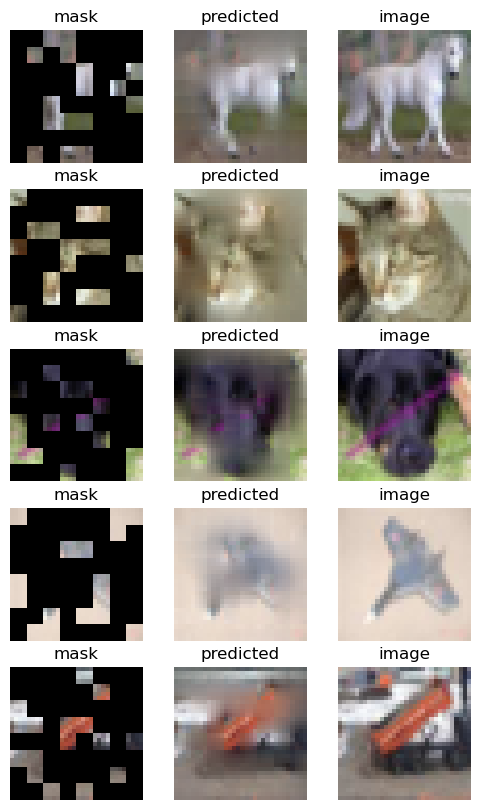

In [26]:
model.eval()

with torch.no_grad():
  ids = np.random.choice(len(cifar_testset), 5, replace=False)
  val_img = X_test[ids, :].to(device)
  predicted_val_img, mask = model(val_img)
  predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
  img = torch.stack([val_img * (1 - mask), predicted_val_img, val_img], dim=1)

plt.figure(figsize=(6, 10))
for idx in range(0,15):
  plt.subplot(5, 3, idx+1)
  row = idx//3
  col = idx - 3*row
  plt.imshow(img[row,col,:,:,:].permute(1,2,0).detach().cpu().numpy().clip(0,1))
  text = "mask" if col==0 else ("predicted" if col==1 else "image")
  plt.title(text)
  plt.grid(False)
  plt.axis('off')

# Fine-tuning a pre-trained ViT model

Now that we have pretrained a ViT encoder using Masked Auto-Encoding, we will fine-tune it specifically for the task of object recognition (classification) on the CIFAR-10 dataset.

Training the same model *from scratch* for this task, for up to 20 epochs, typically yields a test performance below 60% accuracy with clear signs of overfitting (you can also try it for yourself). Let's see if we can do better, in 5 epochs of fine-tuning, if we start from the MAE pretrained weights.

<br>Firstly we will reuse two convenience functions from the previous lab:
- to transform a class probability tensor to class labels
- to compute the prediction accuracy from predicted and ground truth labels

In [27]:
def vector_to_class(x):
  y = torch.argmax(F.softmax(x,dim=1),axis=1)
  return y

In [28]:
def prediction_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

<br>We define the parameters for this fine-tuning step:

In [29]:
# Training parameters
learning_rate = 1e-3
weight_decay = 1e-2
n_epochs = 5
batch_size = 128

# Model parameters
num_classes = 10
pool = 'mean' # you can use 'cls' instead

In [30]:
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

<br>Now, we instantiate a ViT model with the desired parameters, with the pretrained weights of the MAE pre-training:

In [31]:
# Define the ViT model (to be fine-tuned) with the correct arguments:
cifar_model_ft = ViT_Classifier(model.encoder, num_classes=num_classes, pool=pool).to(device)

In [32]:
cifar_model_ft = cifar_model_ft.to(device)

<br>Now, we carry out training on the CIFAR10 dataset.

In [33]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.AdamW(cifar_model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [34]:
cifar_model_ft.train()

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(cifar_train_loader, unit="batch") as tepoch:
    for imgs, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on device
      imgs = imgs.to(device)
      labels = labels.to(device)

      # BEGIN STUDENT CODE: forward and backward passes
      predict = cifar_model_ft(imgs) # predicted logits
      loss = criterion(predict, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # END STUDENT CODE

      # Compute the loss
      train_loss += loss.item()
      # Store labels and class predictions
      all_labels.extend(labels.tolist())
      all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(cifar_train_loader.dataset)))
  print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),np.array(all_labels))))

Epoch 0: 100%|██████████| 391/391 [00:10<00:00, 36.65batch/s]


Epoch 0: Train Loss: 1.4517
Epoch 0: Train Accuracy: 0.4725


Epoch 1: 100%|██████████| 391/391 [00:10<00:00, 36.84batch/s]


Epoch 1: Train Loss: 1.0521
Epoch 1: Train Accuracy: 0.6209


Epoch 2: 100%|██████████| 391/391 [00:10<00:00, 37.10batch/s]


Epoch 2: Train Loss: 0.9381
Epoch 2: Train Accuracy: 0.6634


Epoch 3: 100%|██████████| 391/391 [00:10<00:00, 37.17batch/s]


Epoch 3: Train Loss: 0.8699
Epoch 3: Train Accuracy: 0.6871


Epoch 4: 100%|██████████| 391/391 [00:10<00:00, 36.79batch/s]

Epoch 4: Train Loss: 0.8129
Epoch 4: Train Accuracy: 0.7097


<br>Let's compute the test accuracy, and check that it is indeed a lot better than training from scratch (<60%)!

In [35]:
cifar_model_ft.eval()

all_predicted = []
all_labels = []

with tqdm(cifar_test_loader, unit="batch") as tepoch:
  for imgs, labels in tepoch:
    all_labels.extend(labels.tolist())

    imgs = imgs.to(device)
    predict=cifar_model_ft(imgs)
    all_predicted.extend(vector_to_class(predict).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 79/79 [00:01<00:00, 61.17batch/s]


Test Accuracy: 0.6849


## Linear-Probing

In the previous section, we have allowed all parameters of the ViT to be further fine-tuned given supervised data.

Linear-probing is an alternative to fine-tuning. In linear-probing, most of the parameters of the transformer backbone are frozen after pre-training. The only parameters that are still trainable are those of the linear classification head. In linear-probing, the learnt model is essentially a linear classifier that takes as features a pretrained deep representation.

<br>Linear probing often provides poorer results than fine-tuning (but for a smaller computational budget). This will be true in particular when doing MAE pre-training. Let's verify this.

In [36]:
# Training parameters
learning_rate = 1e-3
weight_decay = 1e-2
n_epochs = 5
batch_size = 128

# Model parameters
num_classes = 10
pool = 'mean'

In [37]:
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

In [38]:
cifar_model_lp = ViT_Classifier(model.encoder, num_classes=num_classes, pool=pool).to(device)

In [39]:
cifar_model_lp = cifar_model_lp.to(device)

<br>Training proceeds similarly to the fine-tuning case, except only the parameters of the ViT `head` should be trained. You can copy-paste the code from the previous section and adapt it. In particular, you should use the `detach=True` argument in the forward call to the model, so that the transformer encoder's parameters (except the classification head) are not backpropagated to.

In [40]:
criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.AdamW(cifar_model_lp.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [41]:
# Training:

cifar_model_lp.train()
"""
Training proceeds similarly to the fine-tuning case, except only the parameters of the ViT `head` should be trained. You can copy-paste the code from the previous section and adapt it. In particular, you should use the `detach=True` argument in the forward call to the model, so that the transformer encoder's parameters (except the classification head) are not backpropagated to.
"""

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(cifar_train_loader, unit="batch") as tepoch:
    for imgs, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on device
      imgs = imgs.to(device)
      labels = labels.to(device)

      predict = cifar_model_lp(imgs, detach=True) # predicted logits
      loss = criterion(predict, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute the loss
      train_loss += loss.item()
      # Store labels and class predictions
      all_labels.extend(labels.tolist())
      all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(cifar_train_loader.dataset)))
  print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),np.array(all_labels))))

Epoch 0: 100%|██████████| 391/391 [00:06<00:00, 56.14batch/s]


Epoch 0: Train Loss: 2.0553
Epoch 0: Train Accuracy: 0.3088


Epoch 1: 100%|██████████| 391/391 [00:06<00:00, 56.13batch/s]


Epoch 1: Train Loss: 1.7847
Epoch 1: Train Accuracy: 0.4155


Epoch 2: 100%|██████████| 391/391 [00:06<00:00, 56.42batch/s]


Epoch 2: Train Loss: 1.6697
Epoch 2: Train Accuracy: 0.4406


Epoch 3: 100%|██████████| 391/391 [00:06<00:00, 56.86batch/s]


Epoch 3: Train Loss: 1.6046
Epoch 3: Train Accuracy: 0.4530


Epoch 4: 100%|██████████| 391/391 [00:06<00:00, 56.88batch/s]


Epoch 4: Train Loss: 1.5624
Epoch 4: Train Accuracy: 0.4597


<br>Compute the accuracy on the test dataset like before:

In [42]:
cifar_model_lp.eval()

all_predicted = []
all_labels = []

with tqdm(cifar_test_loader, unit="batch") as tepoch:
  for imgs, labels in tepoch:
    all_labels.extend(labels.tolist())

    imgs = imgs.to(device)
    predict=cifar_model_lp(imgs)
    all_predicted.extend(vector_to_class(predict).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 79/79 [00:01<00:00, 61.40batch/s]


Test Accuracy: 0.4666


We lost more than 20 points of accuracy. Still, the performance remains reasonable for a 10 class problem considering that we essentially trained a linear model.

MAEs with larger decoder depth typically perform a bit better in linear-probing than MAE models with shallow decoders. Still, MAE is often not the strongest self-supervised learning approach to use in combination with linear-probing.

<br>Nevertheless, it goes without saying that with a higher computational budget, a deeper/wider ViT, and proper use of data augmentation and regularization, much better results can be achieved on this CIFAR-10 dataset exactly with the type of method that we have seen today!